In [1]:
%cd ../

In [2]:
import logging
import numpy as np
import htfa_torch.dtfa as DTFA
import htfa_torch.niidb as niidb
import htfa_torch.utils as utils
import matplotlib.pyplot as plt
import htfa_torch.tardb as tardb


In [3]:
import itertools
from torch.nn.functional import softplus
import matplotlib.patches as mpatches
from ordered_set import OrderedSet

In [4]:
import torch

In [5]:
%matplotlib inline

In [6]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [7]:
scenario = '1'
noise_factor = 1
num_subjects = 20
db_file = 'data/simulated_simplified_data_' + scenario + '_' + str(num_subjects)+ '_' + str(noise_factor) + '.tar'
scenario_name = 'scenario_' + scenario + '_' + str(num_subjects)+ '_' + str(noise_factor)
TRAIN = False
synthetic_db = tardb.FmriTarDataset(db_file)

In [8]:
dtfa = DTFA.DeepTFA(synthetic_db, num_factors=3, embedding_dim=2)

/home/zulqarnain/Code/ntfa_degeneracy/htfa_torch/utils.py:280: RuntimeWarning: overflow encountered in square
  objective = lambda w: np.sum((activations - initial_radial_basis(locations,c,w))**2)
/home/zulqarnain/Code/ntfa_degeneracy/htfa_torch/utils.py:280: RuntimeWarning: overflow encountered in square
  objective = lambda w: np.sum((activations - initial_radial_basis(locations,c,w))**2)


In [9]:
dtfa.num_blocks

160

In [10]:
dtfa.tasks()

['video1',
 'video2',
 'video3',
 'video4',
 'video5',
 'video6',
 'video7',
 'video8']

In [11]:
dtfa.subjects()

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 20, 2, 3, 4, 5, 6, 7, 8, 9]

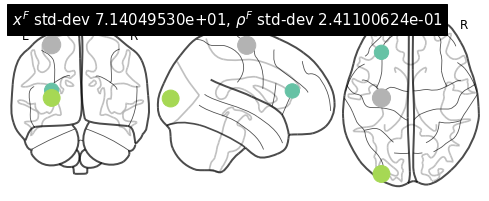

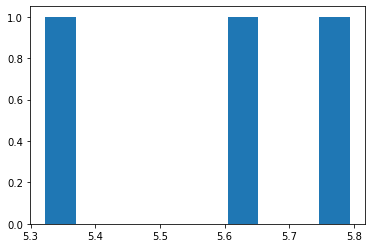

(<nilearn.plotting.displays.OrthoProjector at 0x7f3a6a5d5430>,
 tensor([[-30.,  34.,  16.],
         [-30., -94.,   8.],
         [-30., -14.,  64.]]),
 tensor([5.3228, 5.6488, 5.7935]))

In [12]:
dtfa.visualize_factor_embedding()

In [13]:
if TRAIN:
    losses = dtfa.train(num_steps=1000, learning_rate={'q': 1e-1, 'p': 1e-3}, log_level=logging.INFO, num_particles=1,
                    batch_size=128, use_cuda=True, checkpoint_steps=100, patience=50,
                    blocks_filter=synthetic_db.inference_filter(training=True), l_p=.5, l_s=.5, l_i=5)
else:
    dtfa.load_state('participant_CHECK_04122022_122148_Epoch1000')

In [14]:
if TRAIN:
    utils.plot_losses(losses)

In [15]:
validation_filter = synthetic_db.inference_filter(training=False)
print( [b for (b, block) in dtfa._dataset.blocks.items() if validation_filter(block)])

[0, 9, 18, 27, 36, 45, 54, 63, 64, 73, 82, 91, 100, 109, 118, 127, 128, 137, 146, 155]


In [16]:
classification_results = dtfa.classification_matrix(validation_filter, save_file='scenario_1_classif.pk')

Starting
Processing Block: 0
Processing Block: 9
Processing Block: 18
Processing Block: 27
Processing Block: 36
Processing Block: 45
Processing Block: 54
Processing Block: 63
Processing Block: 64
Processing Block: 73
Processing Block: 82
Processing Block: 91
Processing Block: 100
Processing Block: 109
Processing Block: 118
Processing Block: 127
Processing Block: 128
Processing Block: 137
Processing Block: 146
Processing Block: 155


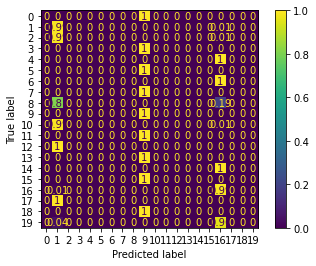

In [17]:
import sklearn
disp = sklearn.metrics.ConfusionMatrixDisplay(np.round(classification_results['soft_maxed'].data.numpy(),2))
disp.plot()

In [19]:
classification_results['validation_tasks']

array(['video1', 'video2', 'video3', 'video4', 'video5', 'video6',
       'video7', 'video8', 'video1', 'video2', 'video3', 'video4',
       'video5', 'video6', 'video7', 'video8', 'video1', 'video2',
       'video3', 'video4'], dtype='<U6')

In [20]:
model_free_energy = []
model_names = []
print('\ttesting for held out blocks:\n',
      [b for (b, block) in dtfa._dataset.blocks.items() if validation_filter(block)])
this_model = dtfa.free_energy(batch_size=64, use_cuda=True, blocks_filter=synthetic_db.inference_filter(training=False),
                 sample_size=100, predictive=True)

model_free_energy.append(this_model)
print('\t',this_model)
# if not 'Base', also check the effect of ablations (subject, task, interaction):
for j in ['sub','task','int']:
    print('\n\tTesting effect of removing',j,'embedding:')
    if j == 'sub':
        ab_s, ab_t, ab_i = True, False, None
    elif j == 'task':
        ab_s, ab_t, ab_i = False, True, None
    elif j == 'int':
        # a bit more complex - we need the mean combination embedding
        hyperparams = dtfa.variational.hyperparams.state_vardict()
        tasks, subjects = dtfa.tasks(), dtfa.subjects()
        z_p_mu = hyperparams['subject_weight']['mu'].data
        z_s_mu = hyperparams['task']['mu'].data
        z_ps_mu = list()
        for p in range(len(subjects)):
            sub_tasks = [b['task'] for b in synthetic_db.blocks.values() if b['subject'] == subjects[p]]
            for t in range(len(sub_tasks)):
                task_index = [i for i, e in enumerate(tasks) if e == sub_tasks[t]]
                joint_embed = torch.cat((z_p_mu[p], z_s_mu[task_index[0]]), dim=-1)
                interaction_embed = dtfa.decoder.interaction_embedding(joint_embed).data
                z_ps_mu.append(interaction_embed.data.numpy())
        z_ps_mu = np.vstack(z_ps_mu)     
        mean_int = list(np.mean(z_ps_mu, axis=0))
        ab_s, ab_t, ab_i = False, False, mean_int
        print('\tmean combination embedding =',mean_int)

#     this_model = dtfa.free_energy(batch_size=128, use_cuda=True, 
#                                   blocks_filter=synthetic_db.inference_filter_blocks(training=False),
#                                   sample_size=100, ablate_subjects=ab_s, ablate_tasks=ab_t, custom_interaction=ab_i,
#                                   predictive=True)
    this_model = dtfa.free_energy(batch_size=64, use_cuda=True, blocks_filter=synthetic_db.inference_filter(training=False),
                 sample_size=100, ablate_subjects=ab_s, ablate_tasks=ab_t, custom_interaction=ab_i, predictive=True)
    model_free_energy.append(this_model)
    print('\t',this_model)

	testing for held out blocks:
 [0, 9, 18, 27, 36, 45, 54, 63, 64, 73, 82, 91, 100, 109, 118, 127, 128, 137, 146, 155]
	 [[-1801851.375, 1803308.5, 1457.0335693359375], [-1800103.625, 1804776.125, 1488.1588134765625]]

	Testing effect of removing sub embedding:
	 [[-1805637.5, 1807099.0, 1461.5972900390625], [-1804395.125, 1807901.625, 1507.3023681640625]]

	Testing effect of removing task embedding:
	 [[-52351.484375, 53810.703125, 1459.2225341796875], [-38389.23828125, 74689.5546875, 1496.940673828125]]

	Testing effect of removing int embedding:
	mean combination embedding = [0.23780516, -1.3126485]
	 [[-1803723.375, 1805184.125, 1460.7913818359375], [-1801229.0, 1806739.125, 1492.045654296875]]


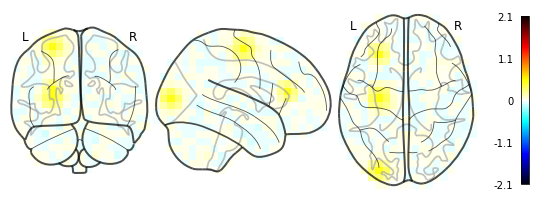

05/05/2022 11:42:25 Reconstruction Error (Frobenius Norm): 1.84943366e+00 out of 2.66710973e+00


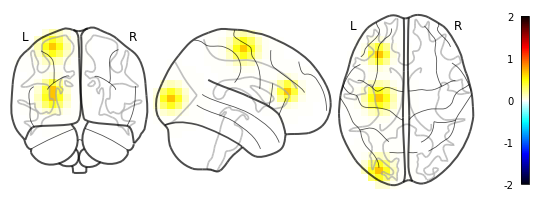

05/05/2022 11:42:26 Reconstruction Error (Frobenius Norm): 1.69281220e+00 out of 2.66710973e+00


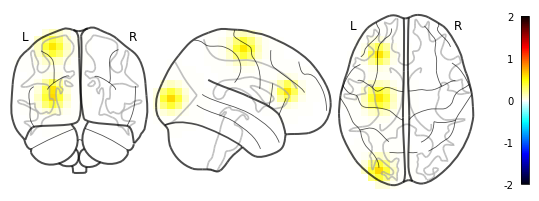

05/05/2022 11:42:27 Reconstruction Error (Frobenius Norm): 1.66448808e+00 out of 2.66710973e+00


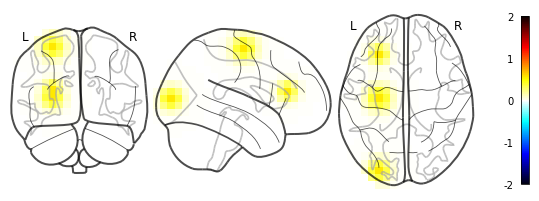

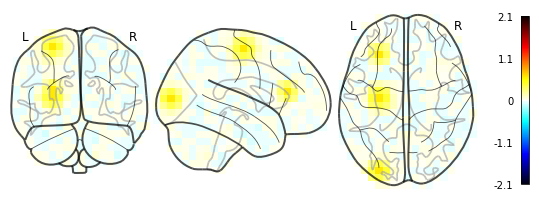

05/05/2022 11:42:30 Reconstruction Error (Frobenius Norm): 1.60364723e+00 out of 3.11117697e+00


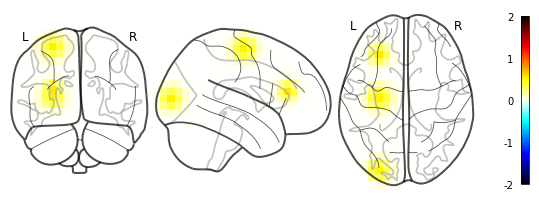

05/05/2022 11:42:32 Reconstruction Error (Frobenius Norm): 1.60137534e+00 out of 3.11117697e+00


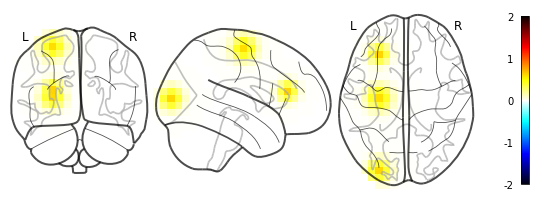

05/05/2022 11:42:33 Reconstruction Error (Frobenius Norm): 1.61829782e+00 out of 3.11117697e+00


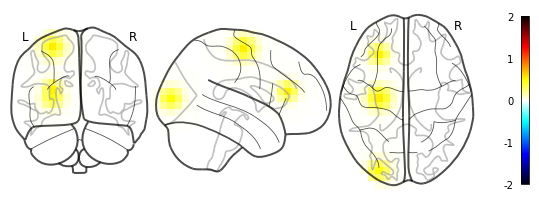

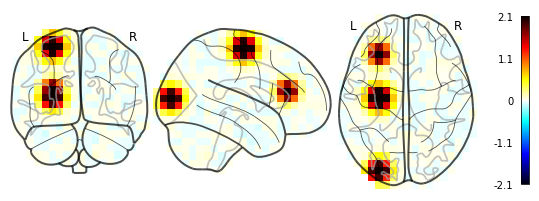

05/05/2022 11:42:36 Reconstruction Error (Frobenius Norm): 1.61807847e+00 out of 1.35042152e+01


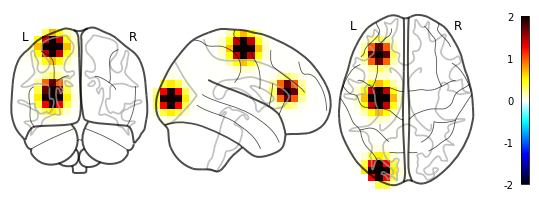

05/05/2022 11:42:38 Reconstruction Error (Frobenius Norm): 1.63431752e+00 out of 1.35042152e+01


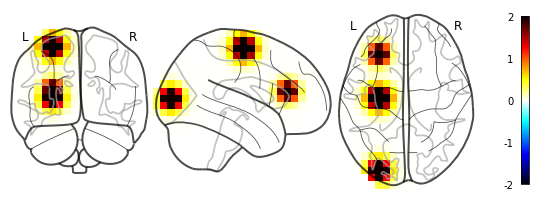

05/05/2022 11:42:40 Reconstruction Error (Frobenius Norm): 1.13908558e+01 out of 1.35042152e+01


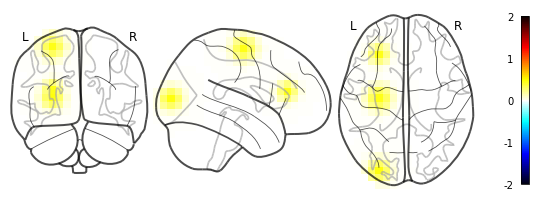

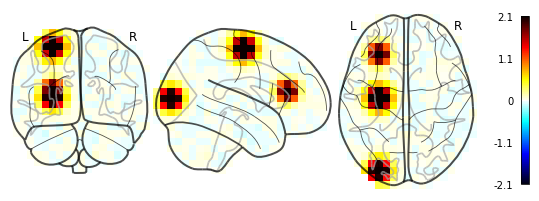

05/05/2022 11:42:43 Reconstruction Error (Frobenius Norm): 1.64429510e+00 out of 1.41888552e+01


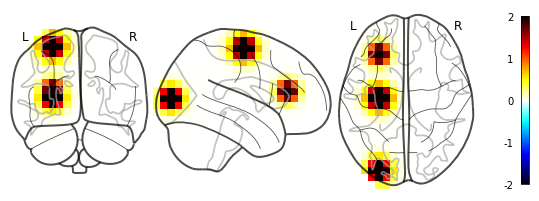

05/05/2022 11:42:45 Reconstruction Error (Frobenius Norm): 1.65706015e+00 out of 1.41888552e+01


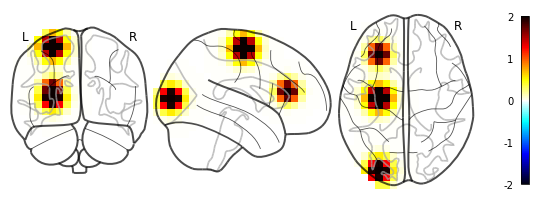

05/05/2022 11:42:47 Reconstruction Error (Frobenius Norm): 1.16070795e+01 out of 1.41888552e+01


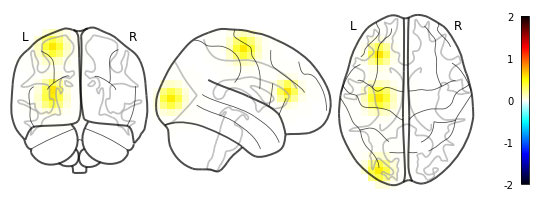

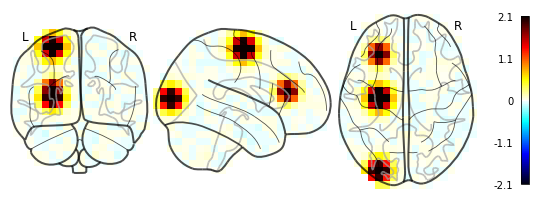

05/05/2022 11:42:50 Reconstruction Error (Frobenius Norm): 1.61846530e+00 out of 1.38194218e+01


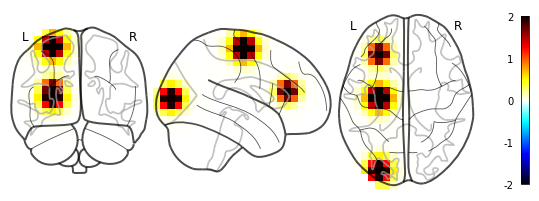

05/05/2022 11:42:52 Reconstruction Error (Frobenius Norm): 1.60939956e+00 out of 1.38194218e+01


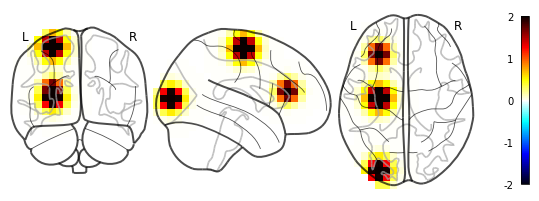

05/05/2022 11:42:54 Reconstruction Error (Frobenius Norm): 1.12445354e+01 out of 1.38194218e+01


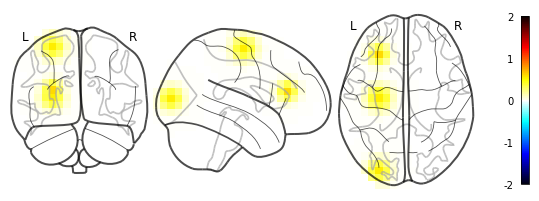

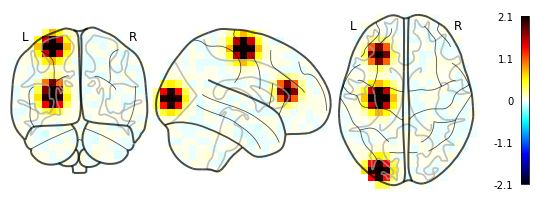

05/05/2022 11:42:58 Reconstruction Error (Frobenius Norm): 1.60049987e+00 out of 1.41446600e+01


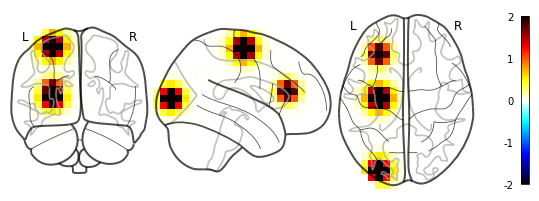

05/05/2022 11:43:00 Reconstruction Error (Frobenius Norm): 1.62155962e+00 out of 1.41446600e+01


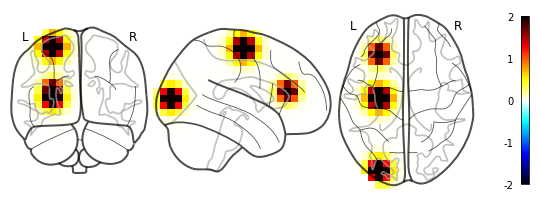

05/05/2022 11:43:02 Reconstruction Error (Frobenius Norm): 1.17186317e+01 out of 1.41446600e+01


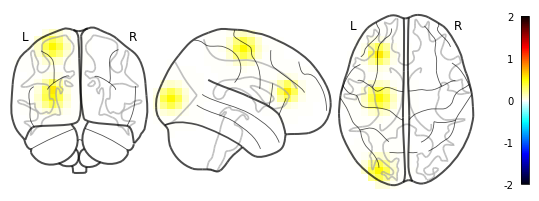

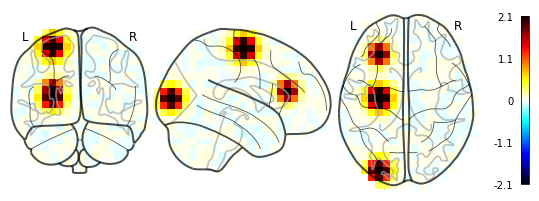

05/05/2022 11:43:07 Reconstruction Error (Frobenius Norm): 1.83395004e+00 out of 1.32305164e+01


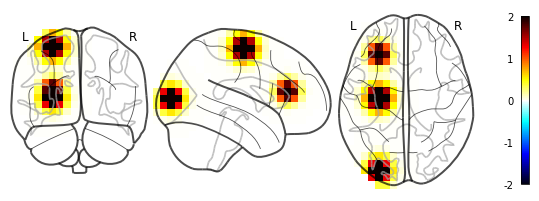

05/05/2022 11:43:09 Reconstruction Error (Frobenius Norm): 1.74910522e+00 out of 1.32305164e+01


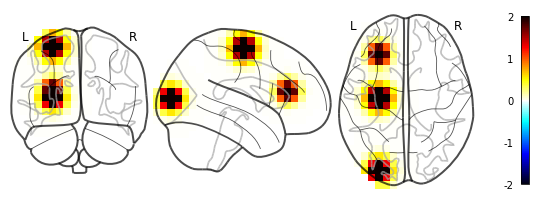

05/05/2022 11:43:11 Reconstruction Error (Frobenius Norm): 1.08627968e+01 out of 1.32305164e+01


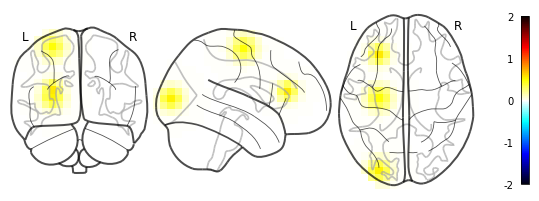

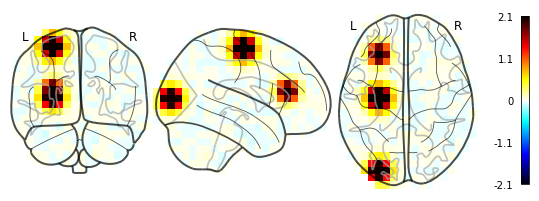

05/05/2022 11:43:16 Reconstruction Error (Frobenius Norm): 1.64798951e+00 out of 1.42025537e+01


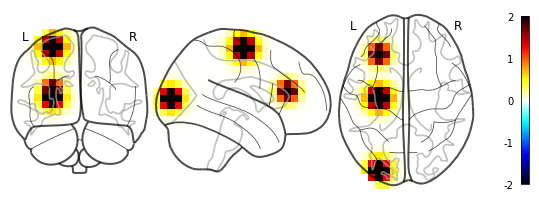

05/05/2022 11:43:19 Reconstruction Error (Frobenius Norm): 1.71512914e+00 out of 1.42025537e+01


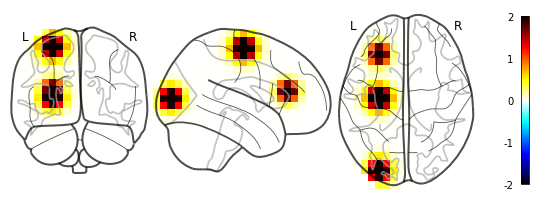

05/05/2022 11:43:21 Reconstruction Error (Frobenius Norm): 1.18964367e+01 out of 1.42025537e+01


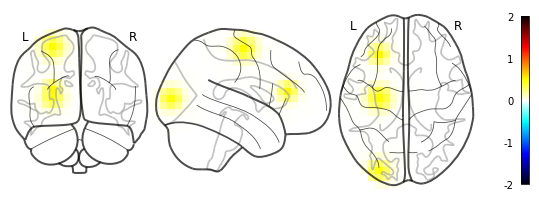

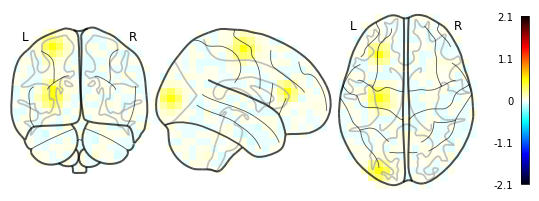

05/05/2022 11:43:26 Reconstruction Error (Frobenius Norm): 1.88677967e+00 out of 2.73431134e+00


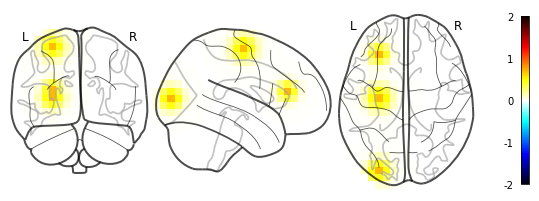

05/05/2022 11:43:28 Reconstruction Error (Frobenius Norm): 1.67567182e+00 out of 2.73431134e+00


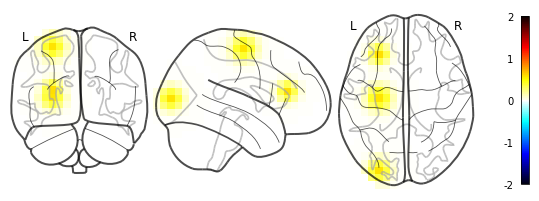

05/05/2022 11:43:31 Reconstruction Error (Frobenius Norm): 1.63121498e+00 out of 2.73431134e+00


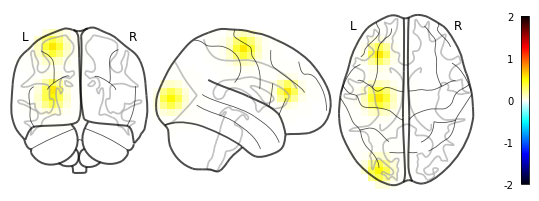

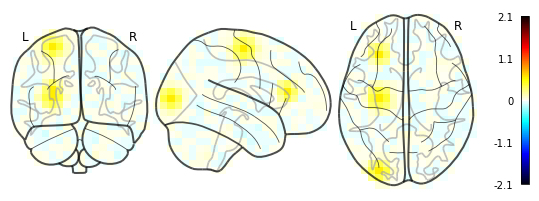

05/05/2022 11:43:36 Reconstruction Error (Frobenius Norm): 1.66048837e+00 out of 3.06894565e+00


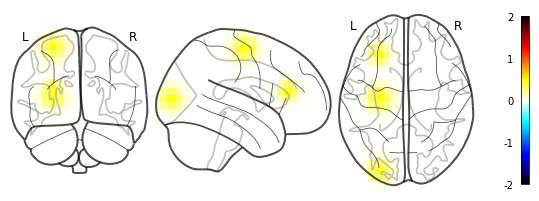

05/05/2022 11:43:38 Reconstruction Error (Frobenius Norm): 1.60607588e+00 out of 3.06894565e+00


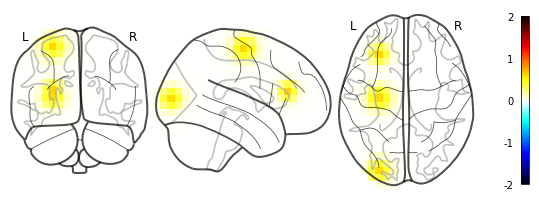

05/05/2022 11:43:41 Reconstruction Error (Frobenius Norm): 1.67197645e+00 out of 3.06894565e+00


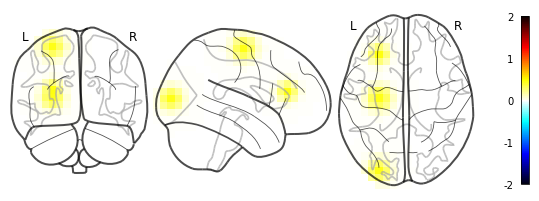

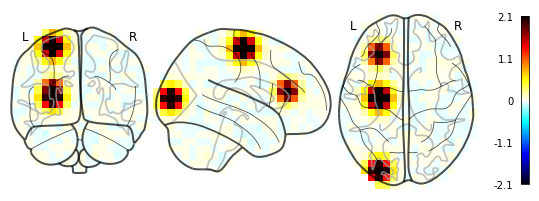

05/05/2022 11:43:46 Reconstruction Error (Frobenius Norm): 1.60545444e+00 out of 1.40052538e+01


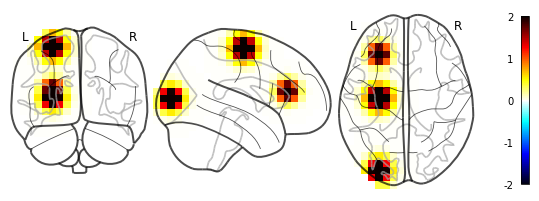

05/05/2022 11:43:49 Reconstruction Error (Frobenius Norm): 1.61458874e+00 out of 1.40052538e+01


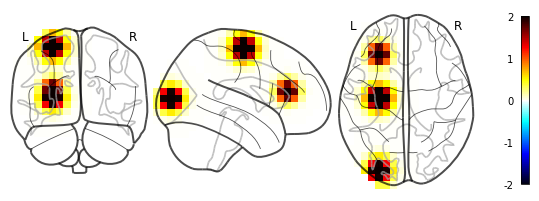

05/05/2022 11:43:51 Reconstruction Error (Frobenius Norm): 1.15361500e+01 out of 1.40052538e+01


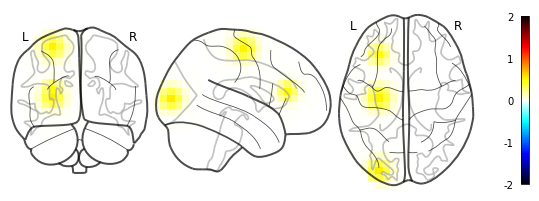

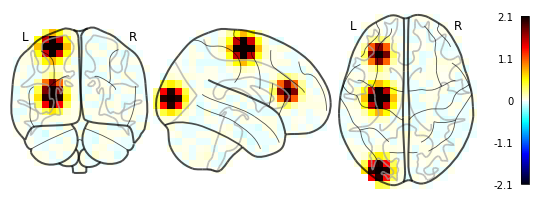

05/05/2022 11:43:57 Reconstruction Error (Frobenius Norm): 1.59849536e+00 out of 1.41346979e+01


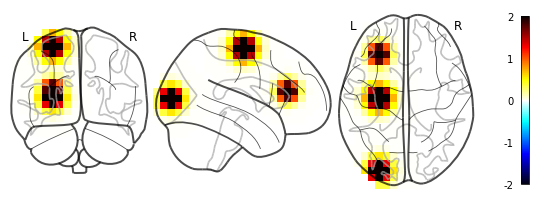

05/05/2022 11:44:00 Reconstruction Error (Frobenius Norm): 1.63728023e+00 out of 1.41346979e+01


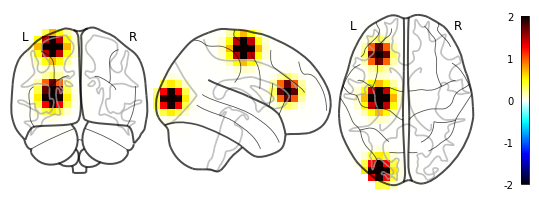

05/05/2022 11:44:03 Reconstruction Error (Frobenius Norm): 1.19467354e+01 out of 1.41346979e+01


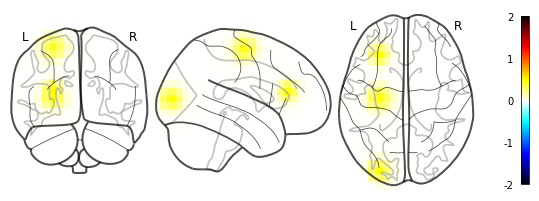

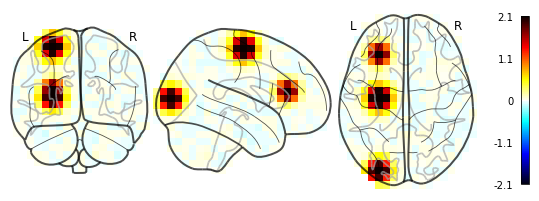

05/05/2022 11:44:09 Reconstruction Error (Frobenius Norm): 1.66084850e+00 out of 1.34962626e+01


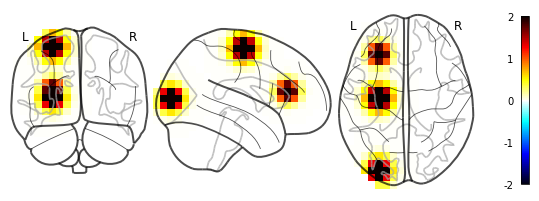

05/05/2022 11:44:11 Reconstruction Error (Frobenius Norm): 1.60927331e+00 out of 1.34962626e+01


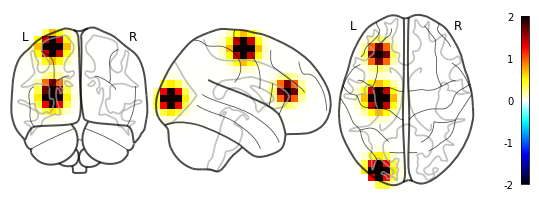

05/05/2022 11:44:14 Reconstruction Error (Frobenius Norm): 1.09388628e+01 out of 1.34962626e+01


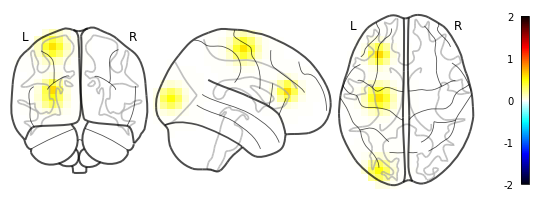

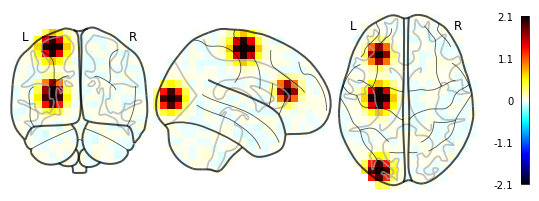

05/05/2022 11:44:21 Reconstruction Error (Frobenius Norm): 1.75745976e+00 out of 1.34456549e+01


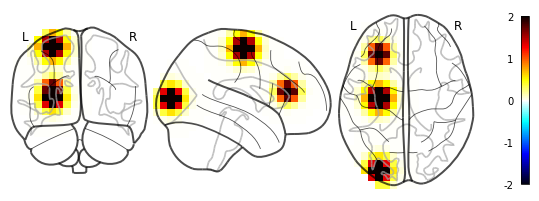

05/05/2022 11:44:24 Reconstruction Error (Frobenius Norm): 1.69898176e+00 out of 1.34456549e+01


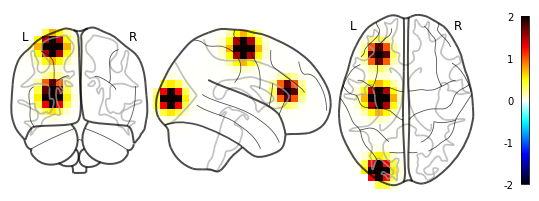

05/05/2022 11:44:28 Reconstruction Error (Frobenius Norm): 1.09684525e+01 out of 1.34456549e+01


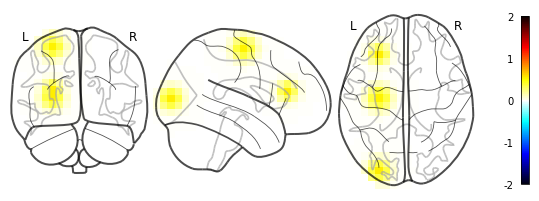

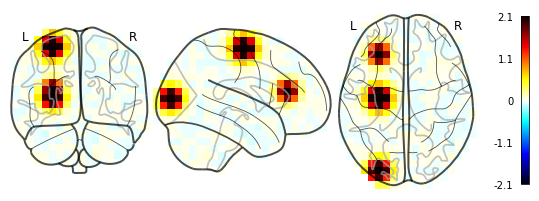

05/05/2022 11:44:35 Reconstruction Error (Frobenius Norm): 1.72733247e+00 out of 1.35685711e+01


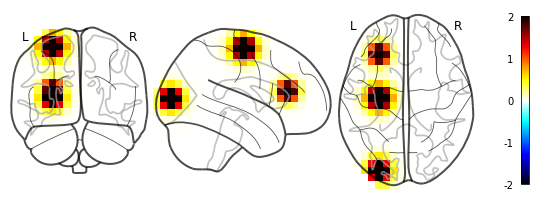

05/05/2022 11:44:38 Reconstruction Error (Frobenius Norm): 1.62750983e+00 out of 1.35685711e+01


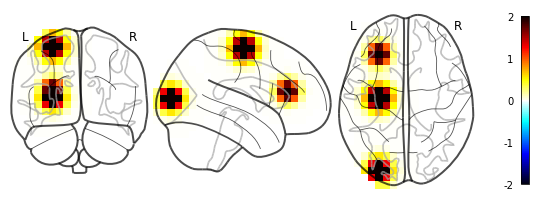

05/05/2022 11:44:41 Reconstruction Error (Frobenius Norm): 1.10156746e+01 out of 1.35685711e+01


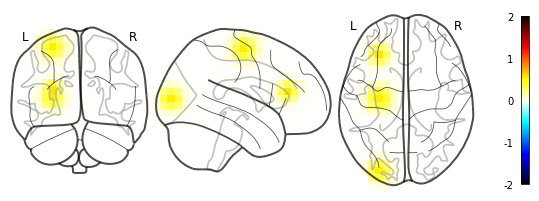

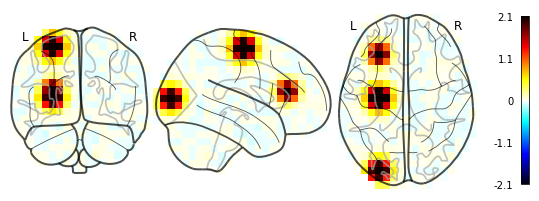

05/05/2022 11:44:48 Reconstruction Error (Frobenius Norm): 1.65527785e+00 out of 1.35818052e+01


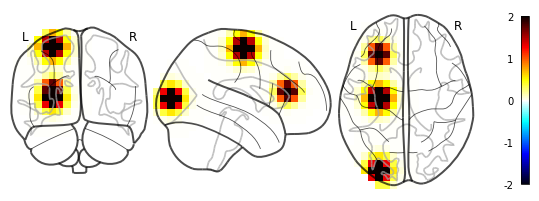

05/05/2022 11:44:52 Reconstruction Error (Frobenius Norm): 1.59915578e+00 out of 1.35818052e+01


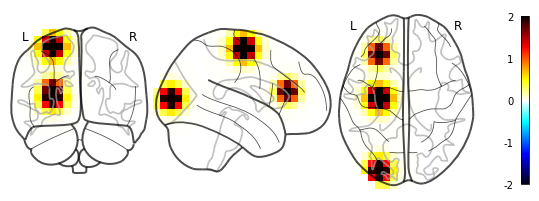

05/05/2022 11:44:55 Reconstruction Error (Frobenius Norm): 1.12787828e+01 out of 1.35818052e+01


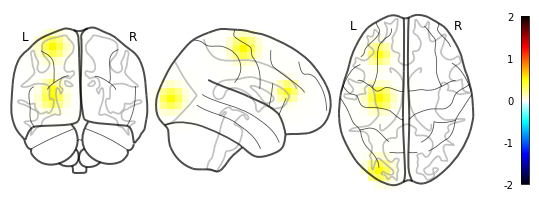

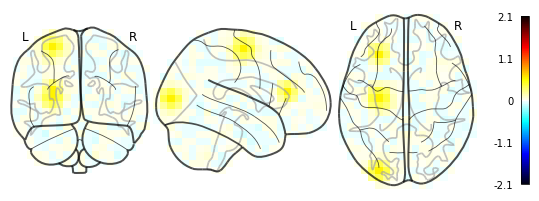

05/05/2022 11:45:02 Reconstruction Error (Frobenius Norm): 1.61067581e+00 out of 3.00722003e+00


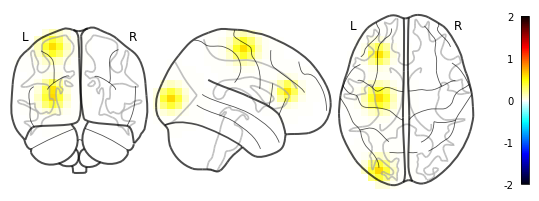

05/05/2022 11:45:06 Reconstruction Error (Frobenius Norm): 1.61148632e+00 out of 3.00722003e+00


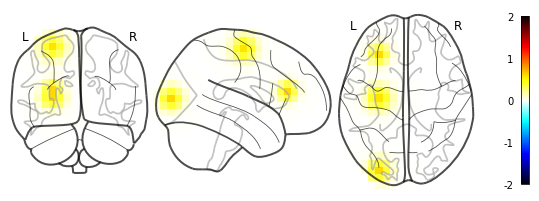

05/05/2022 11:45:09 Reconstruction Error (Frobenius Norm): 1.60208786e+00 out of 3.00722003e+00


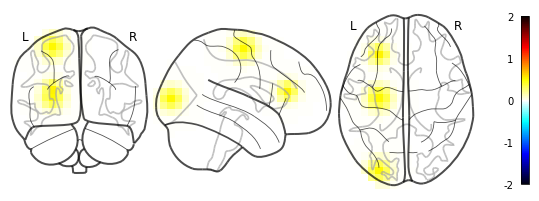

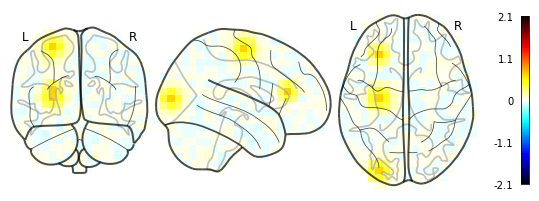

05/05/2022 11:45:16 Reconstruction Error (Frobenius Norm): 1.87325072e+00 out of 3.41362357e+00


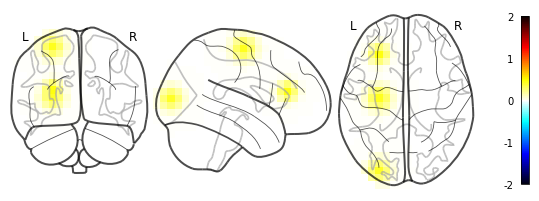

05/05/2022 11:45:20 Reconstruction Error (Frobenius Norm): 1.60642600e+00 out of 3.41362357e+00


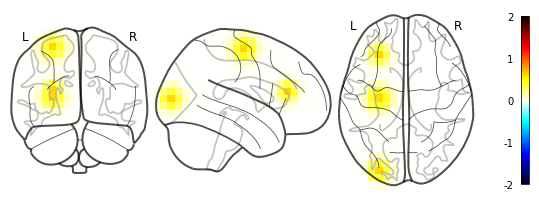

05/05/2022 11:45:24 Reconstruction Error (Frobenius Norm): 1.91218305e+00 out of 3.41362357e+00


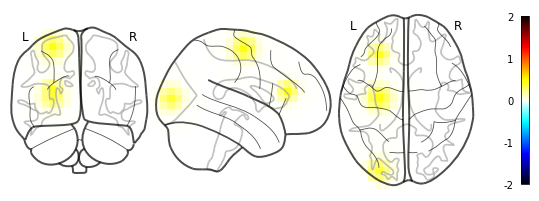

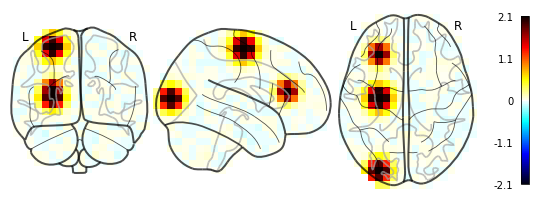

05/05/2022 11:45:32 Reconstruction Error (Frobenius Norm): 1.70668912e+00 out of 1.32185736e+01


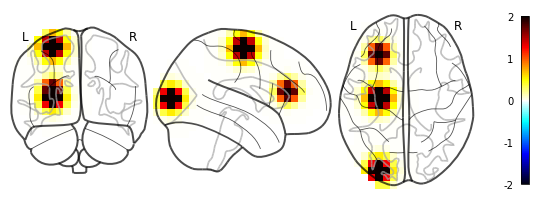

05/05/2022 11:45:35 Reconstruction Error (Frobenius Norm): 1.71645451e+00 out of 1.32185736e+01


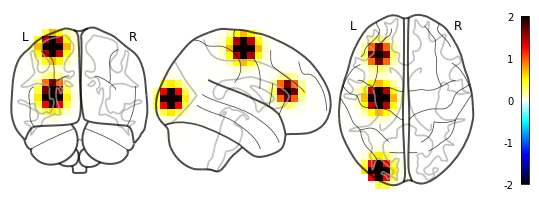

05/05/2022 11:45:39 Reconstruction Error (Frobenius Norm): 1.07833500e+01 out of 1.32185736e+01


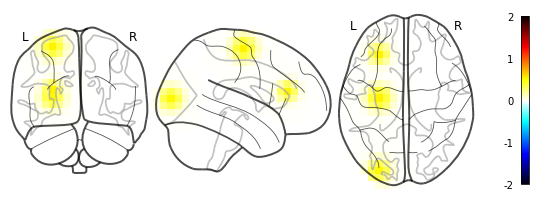

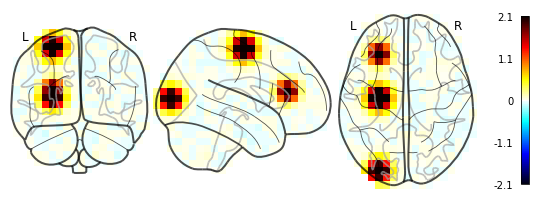

05/05/2022 11:45:47 Reconstruction Error (Frobenius Norm): 1.59836519e+00 out of 1.37117138e+01


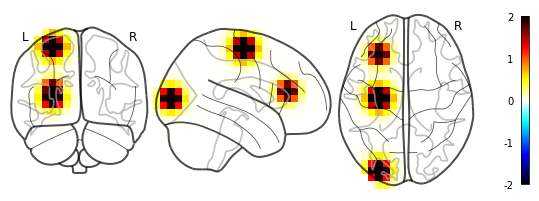

05/05/2022 11:45:51 Reconstruction Error (Frobenius Norm): 1.59937549e+00 out of 1.37117138e+01


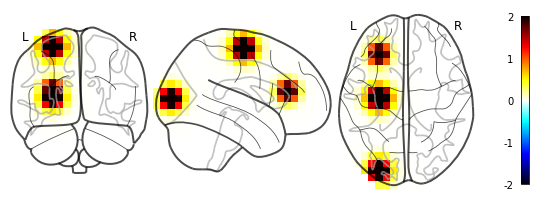

05/05/2022 11:45:54 Reconstruction Error (Frobenius Norm): 1.10397825e+01 out of 1.37117138e+01


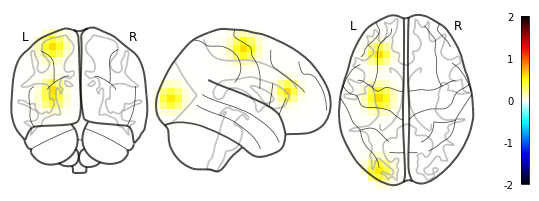

In [21]:
for b in [b for (b, block) in dtfa._dataset.blocks.items() if synthetic_db.inference_filter(training=False)(block)]:
    dtfa.plot_original_brain(b, labeler=lambda b: None, t=None, zscore_bound=2.1)
    dtfa.plot_reconstruction(b, labeler=lambda b: None, t=None, zscore_bound=2)
    dtfa.plot_reconstruction(b, labeler=lambda b: None, t=None, ablate_subjects=True, zscore_bound=2)
    dtfa.plot_reconstruction(b, labeler=lambda b: None, t=None, ablate_tasks=True, zscore_bound=2)

In [22]:
def task_labeler(task):
    return task


def rest_task_labeler(task):
    if task == 'rest':
        return 'Rest'
    else:
        return 'Task'

In [23]:
def subject_labeler(subject):
    return str(subject)

In [24]:
hyperparams = dtfa.variational.hyperparams.state_vardict()
z_s_mu = hyperparams['task']['mu']
z_p_mu = hyperparams['subject_weight']['mu']
tasks = dtfa.tasks()
subjects = dtfa.subjects()
interactions = OrderedSet(list(itertools.product(subjects, tasks)))

In [25]:
subjects[0]

10

In [26]:
dtfa.decoder.interaction_embedding(torch.cat((z_p_mu[1], z_s_mu[0]), dim=-1)).data.numpy()

array([ 0.6391139 , -0.93642986], dtype=float32)

In [27]:
dtfa.decoder.interaction_embedding(torch.cat((z_p_mu[1], z_s_mu[1]), dim=-1))

tensor([ 0.7799, -1.1746], grad_fn=<SqueezeBackward3>)

In [28]:
dtfa.decoder.interaction_embedding(torch.cat((z_p_mu[1], z_s_mu[2]), dim=-1))

tensor([ 0.0877, -1.4092], grad_fn=<SqueezeBackward3>)

In [29]:
def stimulus_labeler(stimulus):
    stim = stimulus[-1]
    if int(stim) == 1 or int(stim) == 2:
        return 'State 0'
    elif int(stim) == 3 or int(stim) == 4:
        return 'State 1'
    elif int(stim) == 5 or int(stim) == 6:
        return 'State 2'
    elif int(stim) == 7 or int(stim) == 8:
        return 'State 3'
    else:
        print ('Error')

/home/zulqarnain/Code/ntfa_degeneracy/htfa_torch/utils.py:153: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


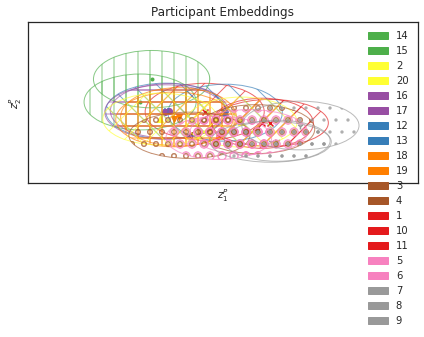

In [30]:
dtfa.scatter_subject_embedding(labeler=subject_labeler, figsize=None, colormap='Set1',
                            filename='subject_norest_subject_embedding' + scenario_name + '.png')

/home/zulqarnain/Code/ntfa_degeneracy/htfa_torch/utils.py:153: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


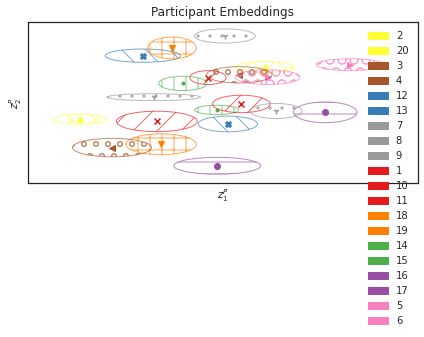

In [31]:
dtfa.scatter_subject_weight_embedding(labeler=subject_labeler, figsize=None, colormap='Set1',
                            filename='subject_norest_subject_weight_embedding' + scenario_name + '.png')

/home/zulqarnain/Code/ntfa_degeneracy/htfa_torch/utils.py:153: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


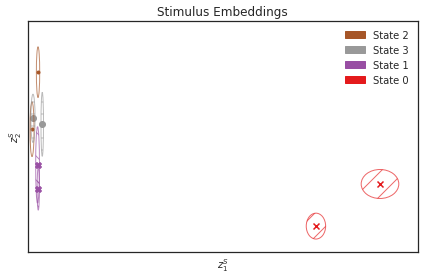

In [32]:
dtfa.scatter_task_embedding(labeler=stimulus_labeler,figsize=None, colormap='Set1',
                            filename='subject_norest_task_embedding' + scenario_name + '.png')

In [33]:
def scatter_interactions_embedding(self, labeler=None, filename='', show=True,
                                   xlims=None, ylims=None, figsize=utils.FIGSIZE,
                                   colormap='Accent', serialize_data=True,
                                   plot_ellipse=True, legend_ordering=None,nstd=3):

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]
    
    if filename == '':
        filename = self.common_name() + '_task_embedding.pdf'
    hyperparams = self.variational.hyperparams.state_vardict()
    tasks = self.tasks()
    subjects = self.subjects()
    z_p_mu = hyperparams['subject_weight']['mu'].data
    z_s_mu = hyperparams['task']['mu'].data
    interactions = OrderedSet(list(itertools.product(subjects, tasks)))
    z_ps_mu = np.zeros(shape=(len(interactions),2))
    count = 0
    for p in range (len(subjects)):
        for t in range(len(tasks)):
            joint_embed = torch.cat((z_p_mu[p], z_s_mu[t]), dim=-1)
            interaction_embed = self.decoder.interaction_embedding(
                joint_embed).data
            z_ps_mu[count,:] = interaction_embed
            count += 1
    embedding_name = 'z^{PS}'

    fig, ax = plt.subplots(facecolor='white', figsize=figsize, frameon=True)
    if xlims is not None:
        ax.set_xlim(xlims)
    if ylims is not None:
        ax.set_ylim(ylims)
    ax.set_xticks([])
    ax.set_yticks([])
    task_colors = ['black','darkgreen','red','blue']
    task_low_embeddings = []
    task_high_embeddings = []

    for i in range(len(z_ps_mu)):
        if stimulus_labeler(interactions[i][1]) == 'State 0':
            edgecolor = task_colors[0]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[0], marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[0], marker='^', s=400, linewidth=4)
            task_low_embeddings.append(z_ps_mu[i,:])
        elif stimulus_labeler(interactions[i][1]) == 'State 1':
            edgecolor = task_colors[1]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[1],marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[1],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 
        elif stimulus_labeler(interactions[i][1]) == 'State 2':
            edgecolor = task_colors[2]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[2],marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[2],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 
        elif stimulus_labeler(interactions[i][1]) == 'State 3':
            edgecolor = task_colors[3]
            if str(interactions[i][0]) == '1':
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[3],marker='o', s=400, linewidth=4)
            else:
                ax.scatter(z_ps_mu[i,0],z_ps_mu[i,1],facecolor='none', edgecolor=task_colors[3],marker='^', s=400, linewidth=4)
            task_high_embeddings.append(z_ps_mu[i,:]) 

    ordered_tasks = ['Baseline','Trial A', 'Trial B', 'Trial C']
    single_task_colors = ['darkgreen','red','blue']
    manual_legend = [mpatches.Patch(color=c,label=t) for (c,t) in zip(task_colors,ordered_tasks)]
    temp_dict = {key:[] for key in subjects}
    linestyle = ['solid','dashed']

    
    if filename is not None:
        fig.savefig(filename)
    if show:
        fig.show()
        
    return task_low_embeddings,task_high_embeddings


In [34]:
def interactions_labeler(subject,task):
    
    return task_labeler(task) + subject_labeler(subject)

<ipython-input-33-90f267d5ea4f>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


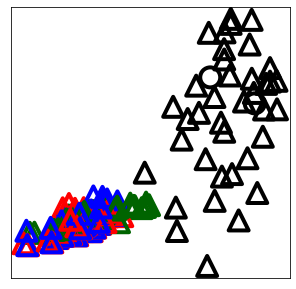

In [35]:
task_low_embeddings,task_high_embeddings= scatter_interactions_embedding(dtfa,labeler=interactions_labeler,
                               filename='subject_norest_interaction_embedding' + scenario_name + '.png',
                               plot_ellipse=True,colormap='tab20',figsize=(5,5),nstd=3)